In [1]:
import sys
import os

discretizer_folder ='../'
sys.path.append(os.path.abspath(discretizer_folder))

In [2]:
import scipy.sparse.linalg as sla
import numpy as np
import sympy
from sympy.interactive import printing
printing.init_printing(use_latex='mathjax')

In [3]:
from sympy.physics.quantum import TensorProduct as kr

In [4]:
from discretizer import Discretizer
from discretizer import momentum_operators

try:
    from types import SimpleNamespace
except: # Python 2
    from argparse import Namespace as SimpleNamespace

import kwant
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
params = {
    "HgTe" : SimpleNamespace(A=3.65, B=-68.6, D=-51.1, M=-0.01, C=0),
    "InAs/GaSb" : SimpleNamespace(A=0.37, B=-66.0, D=-5.8, M=-0.0075, C=0)
}

In [6]:
s0 = sympy.eye(2)
sx = sympy.physics.matrices.msigma(1)
sy = sympy.physics.matrices.msigma(2)
sz = sympy.physics.matrices.msigma(3)

kx, ky, kz = momentum_operators
A, B, D, M, C = sympy.symbols('A B D M C', real=True)

k = sympy.sqrt(kx**2+ky**2)
hamiltonian = (+ C * kr(s0, s0) + M * kr(s0, sz) - D * k**2 * kr(s0, s0)
               - B * k**2 * kr(s0, sz) + A * (kx * kr(sz, sx) - ky * kr(s0, sy)))

hamiltonian

⎡    ⎛  2      2⎞         ⎛  2      2⎞                                        
⎢- B⋅⎝kₓ  + k_y ⎠ + C - D⋅⎝kₓ  + k_y ⎠ + M              A⋅(kₓ + ⅈ⋅k_y)        
⎢                                                                             
⎢                                             ⎛  2      2⎞         ⎛  2      2
⎢             A⋅(kₓ - ⅈ⋅k_y)                B⋅⎝kₓ  + k_y ⎠ + C - D⋅⎝kₓ  + k_y 
⎢                                                                             
⎢                                                                             
⎢                    0                                         0              
⎢                                                                             
⎢                                                                             
⎣                    0                                         0              

                                                                              
                           0                       

In [7]:
# get tight binding Hamiltonian by creating Discretizer instance
tb = Discretizer(hamiltonian, lattice_constant=20, verbose=True)

Discrete coordinates set to:  ['x', 'y']

Function generated for (0, 1):
def _anonymous_func(site1, site2, p):
    (x, y, ) = site2.pos
    A, D, B = p.A, p.D, p.B
    return (np.array([[B/400 + D/400, -A/40, 0, 0], [A/40, -B/400 + D/400, 0, 0], [0, 0, B/400 + D/400, -A/40], [0, 0, A/40, -B/400 + D/400]]))

Function generated for (1, 0):
def _anonymous_func(site1, site2, p):
    (x, y, ) = site2.pos
    A, D, B = p.A, p.D, p.B
    return (np.array([[B/400 + D/400, 1.j*A/40, 0, 0], [1.j*A/40, -B/400 + D/400, 0, 0], [0, 0, B/400 + D/400, -1.j*A/40], [0, 0, -1.j*A/40, -B/400 + D/400]]))

Function generated for (0, 0):
def _anonymous_func(site, p):
    (x, y, ) = site.pos
    C, M, D, B = p.C, p.M, p.D, p.B
    return (np.array([[-B/100 + C - D/100 + M, 0, 0, 0], [0, B/100 + C - D/100 - M, 0, 0], [0, 0, -B/100 + C - D/100 + M, 0], [0, 0, 0, B/100 + C - D/100 - M]]))



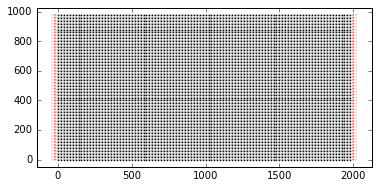

In [8]:
L, W = 2000, 1000

def shape(pos):
    (x, y) = pos
    return (0 <= y < W and 0 <= x < L)

def lead_shape(pos):
    (x, y) = pos
    return (0 <= y < W)


# call helper method of Discretizer instance
# to easily create Kwant's system
sys = tb.build(shape, (0, 0))
lead = tb.build(lead_shape, (0, 0), symmetry=(-1, 0))

sys.attach_lead(lead)
sys.attach_lead(lead.reversed())

sys = sys.finalized()

kwant.plot(sys)
plt.show()

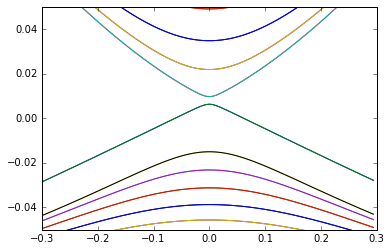

In [9]:
material = "HgTe"
kwant.plotter.bands(sys.leads[0], args=[params[material]],
                    momenta=np.linspace(-0.3, 0.3, 100, endpoint=False), show=False)
if material == "HgTe":
    plt.ylim(-0.05, 0.05)
else:
    plt.ylim(-0.02, 0.02)

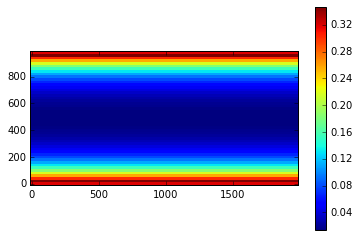

In [10]:
E = 0.0
ldos = kwant.ldos(sys, energy=E, args=[params[material]])

ldos_sum = ldos[::4] + ldos[1::4] + ldos[2::4] + ldos[3::4]
kwant.plotter.map(sys, ldos_sum)
plt.show()